# Zoning & Land Use Applications

In this notebook I look at trends in Zoning & Land Use applications in NYC over time. The data includes ZAP applications from 2010 to 2019 and was pulled from the NYC Planning Labs website:

https://zap.planning.nyc.gov/projects?boroughs=Brooklyn&dcp_publicstatus=Completed%2CFiled%2CIn%20Public%20Review%2CUnknown

Unfortunately, the data includes little detailed time series information. The only project time information included in the data is in the "lastmilest" column, which isn't terribly informative.

## Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from fiona.crs import from_epsg
import matplotlib.pylab as plt
from matplotlib import cm
import requests
import numpy as np
import copy

### ZAP for all of NYC

In [2]:
# Uncomment one or the other
# all_data = 'data/primary_source_data/zap_shp_all/projects.shp'
data_10to19 = 'data/primary_source_data/zap_shp_10to19/projects.shp'

In [3]:
zap = gpd.read_file(data_10to19)
zap.head()

,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_1,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry
0,2019Q0306,19FDO001Q,Unlisted,FDNY EMS Station 49 Site Selection/Acquisition,FDNY seeks the site selection and acquisition ...,In Public Review,Queens,ULURP,QN01,PC,...,0.0,0.0,0.0,FDNY,2019-07-15,2796,0,None,190424PCQ,None
1,2019R0150,07DEP063R,None,Whitlock Avenue Bluebelt Site Sel and Acq,Co-applicants DFTA and DCAS propose an acquisi...,In Public Review,Staten Island,ULURP,SI02,PC,...,0.0,0.0,0.0,Charles Olson,2019-07-15,2796,1,"-74.1117838363248,40.5943308525111",190431PCR,"POLYGON ((-74.1114408366564 40.5946257741663, ..."
2,P2017M0377,18HPD086M,Unlisted,NMEIII West 140th and West 150th,"Application for acquisition, UDAAP designation...",In Public Review,Manhattan,ULURP,MN10,HA;PQ,...,0.0,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9412244805403,40.8223614517972",190427HAM;190428PQM,(POLYGON ((-73.94012879860441 40.8261366025728...
3,P2018M0335,19DCP116M,Unlisted,La Hermosa,This is a private application by La Hermosa Ch...,In Public Review,Manhattan,ULURP,MN10,ZM;ZR;ZS,...,0.0,0.0,0.0,La Hermosa Christian Church,2019-07-15,2796,1,"-73.9494413207882,40.7973858780527",190434ZMM;190435ZSM;190436ZSM;N190433ZRM,"POLYGON ((-73.9493065883876 40.7976118008611, ..."
4,P2018K0064,None,None,Brownsville South NCP Cluster,This is an application by NYC Department of Ho...,In Public Review,Brooklyn,ULURP,BK16,HA;HU,...,0.0,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9047495643509,40.662178928569",190373HAK;190374HUK,"(POLYGON ((-73.9052126023041 40.6566744558373,..."


In [6]:
# Census shapefile contents
files = !ls data/primary_source_data/census_tracts
print(list(enumerate(files)))

[(0, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.dbf'), (1, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.prj'), (2, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.shp'), (3, 'geo_export_a1169309-1083-403c-8f43-77f62e2a399e.shx')]


In [7]:
# Census tracts for all of NYC
shp = files[2]
loc = 'data/primary_source_data/census_tracts/' + shp
cen_tracts = gpd.GeoDataFrame.from_file(loc)
cen_tracts.rename(columns={'puma':'GeoID'}, inplace=True)
cen_tracts['GeoID'] = cen_tracts['GeoID'].astype('int')
cen_tracts['ctlabel'] = cen_tracts['ctlabel'].astype('float')
cen_tracts.to_crs(epsg=2263, inplace = True)
cen_tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,GeoID,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9.0,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375973 173705.5001830519,..."
1,1,1009800,Manhattan,I,009800,98.0,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.5070190424 214848.8975829605,..."
2,1,1010000,Manhattan,I,010000,100.0,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861348 216013.1307982849,..."
3,1,1010200,Manhattan,I,010200,102.0,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845678 216507.687011669, ..."
4,1,1010400,Manhattan,I,010400,104.0,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((991325.8815917961 217001.6885985838,..."


### Dealing with latitude and longitude

In [8]:
print("Number of projects in NYC missing latitude-longitude information for the project center: {}".format\
      (len(zap[zap['has_centro']==0])))

Number of projects in NYC missing latitude-longitude information for the project center: 321


In [9]:
# Create a dataframe where all rows have lon lat info
zap_ll = zap[zap['has_centro']!=0]
zap_ll.to_crs(epsg=2263, inplace = True)
zap_ll.head()

/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_1,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry
1,2019R0150,07DEP063R,None,Whitlock Avenue Bluebelt Site Sel and Acq,Co-applicants DFTA and DCAS propose an acquisi...,In Public Review,Staten Island,ULURP,SI02,PC,...,0.0,0.0,0.0,Charles Olson,2019-07-15,2796,1,"-74.1117838363248,40.5943308525111",190431PCR,"POLYGON ((953300.7603774786 155934.2994017524,..."
2,P2017M0377,18HPD086M,Unlisted,NMEIII West 140th and West 150th,"Application for acquisition, UDAAP designation...",In Public Review,Manhattan,ULURP,MN10,HA;PQ,...,0.0,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9412244805403,40.8223614517972",190427HAM;190428PQM,(POLYGON ((1000819.725050635 240266.7258809159...
3,P2018M0335,19DCP116M,Unlisted,La Hermosa,This is a private application by La Hermosa Ch...,In Public Review,Manhattan,ULURP,MN10,ZM;ZR;ZS,...,0.0,0.0,0.0,La Hermosa Christian Church,2019-07-15,2796,1,"-73.9494413207882,40.7973858780527",190434ZMM;190435ZSM;190436ZSM;N190433ZRM,"POLYGON ((998285.7296142729 229872.5220336417,..."
4,P2018K0064,None,None,Brownsville South NCP Cluster,This is an application by NYC Department of Ho...,In Public Review,Brooklyn,ULURP,BK16,HA;HU,...,0.0,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9047495643509,40.662178928569",190373HAK;190374HUK,(POLYGON ((1010549.803359459 178534.8263790921...
5,P2015M0443,15HPD078M,Type II,437 West 126th Street,"Acquisition, Disposition and UDAAP designation...",In Public Review,Manhattan,ULURP,MN09,HA;PQ,...,0.0,0.0,0.0,HPD,2019-07-01,2796,1,"-73.9545029648572,40.8130818307919",C190127PQM;C190128HAM,"POLYGON ((996909.1901855465 235506.6970214476,..."


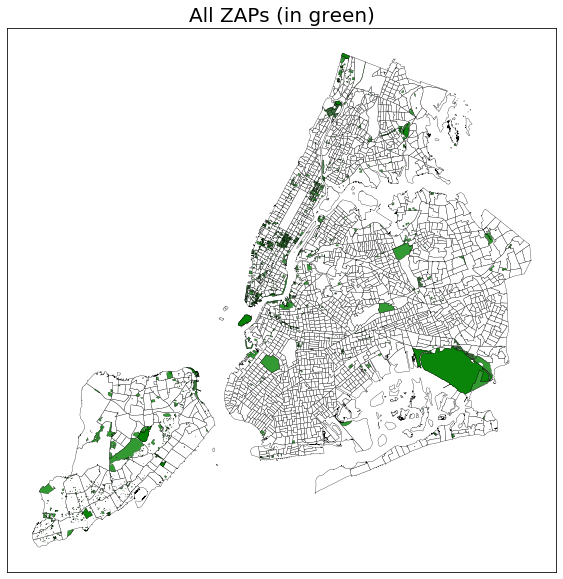

In [65]:
# ZAPs plotted
f, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cen_tracts.plot(alpha=1,linewidth=0.3,ax=ax,color='w',edgecolor='black')
zap_ll.plot(alpha=.8,linewidth=0.3,ax=ax,color='g',edgecolor='black')
plt.title("All ZAPs (in green)", fontsize=20)
plt.show()

In [11]:
# Proportion of zoned land in NYC to all land
print("{}%".format(round(zap_ll.geometry.area.sum() / cen_tracts.geometry.area.sum()*100, 3)))

9.26%


## ZAP count and percentage of land covered by ZAP

In [13]:
# Get counts per location
zap_bor_count = zap_ll.groupby(['dcp_boroug']).count()
zap_bor_count.reset_index(inplace=True)
zap_bor_count = zap_bor_count[['dcp_boroug', 'dcp_name']]
# Remove "Citywide" because it has very little data (mostly missing lat lon and geometry)
zap_bor_count = zap_bor_count[zap_bor_count.dcp_boroug != 'Citywide']
zap_bor_count.reset_index(drop=True, inplace=True)
zap_bor_count.rename(columns={'dcp_name':'count'}, inplace=True)
zap_bor_count

,dcp_boroug,count
0,Bronx,215
1,Brooklyn,361
2,Manhattan,867
3,Queens,256
4,Staten Island,773


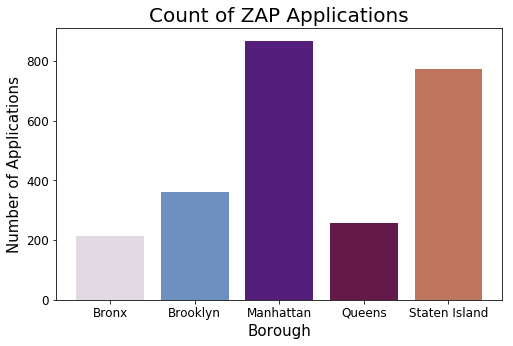

In [14]:
# Raw count for all ZAPs with complete lat lon data
x = zap_bor_count['dcp_boroug']
y = zap_bor_count['count']

plt.figure(figsize=(8,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("Count of ZAP Applications", fontsize=20)
plt.xlabel("Borough", fontsize=15)
plt.ylabel("Number of Applications", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [15]:
zap_ll['shp_area'] = zap_ll['geometry'].area
zap_ll.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry,shp_area
1,2019R0150,07DEP063R,None,Whitlock Avenue Bluebelt Site Sel and Acq,Co-applicants DFTA and DCAS propose an acquisi...,In Public Review,Staten Island,ULURP,SI02,PC,...,0.0,0.0,Charles Olson,2019-07-15,2796,1,"-74.1117838363248,40.5943308525111",190431PCR,"POLYGON ((953300.7603774786 155934.2994017524,...",36483.757857
2,P2017M0377,18HPD086M,Unlisted,NMEIII West 140th and West 150th,"Application for acquisition, UDAAP designation...",In Public Review,Manhattan,ULURP,MN10,HA;PQ,...,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9412244805403,40.8223614517972",190427HAM;190428PQM,(POLYGON ((1000819.725050635 240266.7258809159...,10498.154458
3,P2018M0335,19DCP116M,Unlisted,La Hermosa,This is a private application by La Hermosa Ch...,In Public Review,Manhattan,ULURP,MN10,ZM;ZR;ZS,...,0.0,0.0,La Hermosa Christian Church,2019-07-15,2796,1,"-73.9494413207882,40.7973858780527",190434ZMM;190435ZSM;190436ZSM;N190433ZRM,"POLYGON ((998285.7296142729 229872.5220336417,...",15231.345935
4,P2018K0064,None,None,Brownsville South NCP Cluster,This is an application by NYC Department of Ho...,In Public Review,Brooklyn,ULURP,BK16,HA;HU,...,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9047495643509,40.662178928569",190373HAK;190374HUK,(POLYGON ((1010549.803359459 178534.8263790921...,15024.585086
5,P2015M0443,15HPD078M,Type II,437 West 126th Street,"Acquisition, Disposition and UDAAP designation...",In Public Review,Manhattan,ULURP,MN09,HA;PQ,...,0.0,0.0,HPD,2019-07-01,2796,1,"-73.9545029648572,40.8130818307919",C190127PQM;C190128HAM,"POLYGON ((996909.1901855465 235506.6970214476,...",5043.536715


In [16]:
# Get total ZAP area per location
zap_bor_area = zap_ll.groupby(['dcp_boroug']).sum()
zap_bor_area.reset_index(inplace=True)
zap_bor_area = zap_bor_area[['dcp_boroug', 'shp_area']]
# Remove "Citywide" because it has very little data (mostly missing lat lon and geometry)
zap_bor_area = zap_bor_area[zap_bor_area.dcp_boroug != 'Citywide']
zap_bor_area.reset_index(drop=True, inplace=True)
zap_bor_area

,dcp_boroug,shp_area
0,Bronx,3.709525e+07
1,Brooklyn,6.149641e+07
2,Manhattan,9.018588e+07
3,Queens,4.374549e+08
4,Staten Island,1.536107e+08


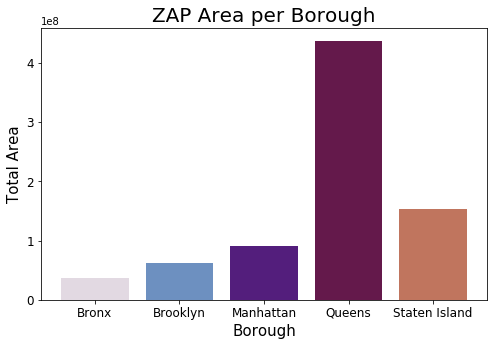

In [17]:
# Total ZAP area per borough with complete lat lon data
x = zap_bor_area['dcp_boroug']
y = zap_bor_area['shp_area']

plt.figure(figsize=(8,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("ZAP Area per Borough", fontsize=20)
plt.xlabel("Borough", fontsize=15)
plt.ylabel("Total Area", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [18]:
# Get area of all census tracts for the normalization that follows
cen_tracts_area = cen_tracts.groupby('boro_name').sum()
cen_tracts_area.reset_index()

,boro_name,ctlabel,GeoID,shape_area,shape_leng
0,Bronx,82904.44,1256176,1.186612e+09,2.912805e+06
1,Brooklyn,379893.07,3047433,1.937567e+09,5.615344e+06
2,Manhattan,41151.04,1096036,6.365332e+08,1.926291e+06
3,Queens,373839.55,2743706,3.044772e+09,6.546338e+06
4,Staten Island,26534.89,433138,1.623921e+09,1.897099e+06


In [68]:
# Merge 
zap_bor_area_merge = zap_bor_area.merge(cen_tracts_area, how='left', left_on='dcp_boroug', right_on='boro_name')
zap_bor_area_merge.rename(columns={'shp_area':'zap_area', 'shape_area':'total_area'}, inplace=True)
zap_bor_area_merge['zap_to_total_area'] = zap_bor_area_merge['zap_area']/zap_bor_area_merge['total_area']
zap_bor_area_merge

,dcp_boroug,zap_area,ctlabel,GeoID,total_area,shape_leng,zap_to_total_area
0,Bronx,3.709525e+07,82904.44,1256176,1.186612e+09,2.912805e+06,0.031261
1,Brooklyn,6.149641e+07,379893.07,3047433,1.937567e+09,5.615344e+06,0.031739
2,Manhattan,9.018588e+07,41151.04,1096036,6.365332e+08,1.926291e+06,0.141683
3,Queens,4.374549e+08,373839.55,2743706,3.044772e+09,6.546338e+06,0.143674
4,Staten Island,1.536107e+08,26534.89,433138,1.623921e+09,1.897099e+06,0.094593


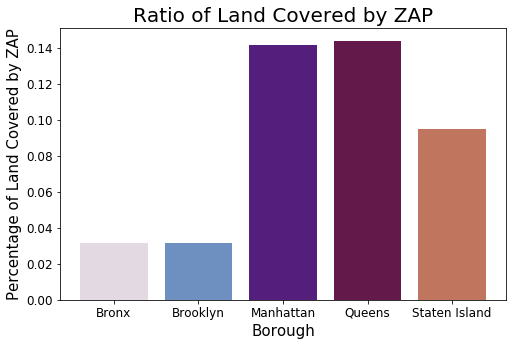

In [69]:
# Percentage of borough with ZAP applications
x = zap_bor_area_merge['dcp_boroug']
y = zap_bor_area_merge['zap_to_total_area']

plt.figure(figsize=(8,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("Ratio of Land Covered by ZAP", fontsize=20)
plt.xlabel("Borough", fontsize=15)
plt.ylabel("Percentage of Land Covered by ZAP", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Note:

The previous two plots relate to the total amount of land that has been included in a ZAP application at any time between 2010 and 2019. In the first of the two plots, we see the total amount of area in each borough that has been included in ZAP applications. In the second plot, we see ther percentage of all land in each borough that has been included in ZAP applications.

## ZAP for Brooklyn and Red Hook only

In [22]:
zap_bk = zap_ll[zap_ll['dcp_boroug']=='Brooklyn']
zap_bk.head()

,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry,shp_area
4,P2018K0064,None,None,Brownsville South NCP Cluster,This is an application by NYC Department of Ho...,In Public Review,Brooklyn,ULURP,BK16,HA;HU,...,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9047495643509,40.662178928569",190373HAK;190374HUK,(POLYGON ((1010549.803359459 178534.8263790921...,15024.585086
6,P2017K0368,18HPD049K,Unlisted,Brownsville North - Ocean Hill NCP Cluster,This is an application by NYC HPD for an Urban...,In Public Review,Brooklyn,ULURP,BK16,HA,...,0.0,0.0,NYC HPD,2019-07-01,2796,1,"-73.9192641619413,40.6726268355633",C190177HAK,(POLYGON ((1006622.065612798 182900.1192015885...,13008.745434
8,P2016K0311,18DCP130K,Unlisted,2 Howard Avenue Rezoning,This is a private application for zoning map a...,In Public Review,Brooklyn,ULURP,BK03,ZM;ZR,...,0.0,0.0,Merrick Capital Corp.,2019-07-01,2796,1,"-73.9214021232532,40.6884468042699",C180292ZMK;N180293ZRK,"POLYGON ((1006105.010192861 190055.1885985638,...",20074.540304
22,P2013K0549,17DCP205K,Unlisted,1050 Pacific Street Rezoning,This is a private application by 1050 Pacific ...,In Public Review,Brooklyn,ULURP,BK08,ZM;ZR,...,0.0,0.0,Mark Rigerman,2019-05-28,2796,1,"-73.9580891085031,40.6785645542978",C160175ZMK;N160176ZRK,"POLYGON ((995792.227600092 186394.1401976839, ...",61783.066447
23,P2015K0351,16DCP134K,Unlisted,1010 Pacific Street Rezoning,This is a private application by 1010 Pacific ...,In Public Review,Brooklyn,ULURP,BK08,ZM;ZR,...,0.0,0.0,1010 Pacific Street LLC,2019-05-28,2796,1,"-73.959537931908,40.6789975203786",C180042ZMK;N180043ZRK,"POLYGON ((995674.6376342799 186563.1213988735,...",49208.873678


In [23]:
print("Number of Brooklyn ZAP applications (with lon lat info): {}".format(zap_bk.shape[0]))

Number of Brooklyn ZAP applications (with lon lat info): 361


### ZAP for Red Hook only

In [24]:
zap_ll_copy = copy.deepcopy(zap_ll)
zap_ll_copy.head()

,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry,shp_area
1,2019R0150,07DEP063R,None,Whitlock Avenue Bluebelt Site Sel and Acq,Co-applicants DFTA and DCAS propose an acquisi...,In Public Review,Staten Island,ULURP,SI02,PC,...,0.0,0.0,Charles Olson,2019-07-15,2796,1,"-74.1117838363248,40.5943308525111",190431PCR,"POLYGON ((953300.7603774786 155934.2994017524,...",36483.757857
2,P2017M0377,18HPD086M,Unlisted,NMEIII West 140th and West 150th,"Application for acquisition, UDAAP designation...",In Public Review,Manhattan,ULURP,MN10,HA;PQ,...,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9412244805403,40.8223614517972",190427HAM;190428PQM,(POLYGON ((1000819.725050635 240266.7258809159...,10498.154458
3,P2018M0335,19DCP116M,Unlisted,La Hermosa,This is a private application by La Hermosa Ch...,In Public Review,Manhattan,ULURP,MN10,ZM;ZR;ZS,...,0.0,0.0,La Hermosa Christian Church,2019-07-15,2796,1,"-73.9494413207882,40.7973858780527",190434ZMM;190435ZSM;190436ZSM;N190433ZRM,"POLYGON ((998285.7296142729 229872.5220336417,...",15231.345935
4,P2018K0064,None,None,Brownsville South NCP Cluster,This is an application by NYC Department of Ho...,In Public Review,Brooklyn,ULURP,BK16,HA;HU,...,0.0,0.0,HPD,2019-07-15,2796,1,"-73.9047495643509,40.662178928569",190373HAK;190374HUK,(POLYGON ((1010549.803359459 178534.8263790921...,15024.585086
5,P2015M0443,15HPD078M,Type II,437 West 126th Street,"Acquisition, Disposition and UDAAP designation...",In Public Review,Manhattan,ULURP,MN09,HA;PQ,...,0.0,0.0,HPD,2019-07-01,2796,1,"-73.9545029648572,40.8130818307919",C190127PQM;C190128HAM,"POLYGON ((996909.1901855465 235506.6970214476,...",5043.536715


In [25]:
# Save the polygon data and get centroids of polygons for spatial join
zap_ll_copy['poly_geo'] = zap_ll_copy['geometry']
zap_ll_copy['geometry'] = zap_ll_copy['geometry'].centroid

In [26]:
# Pull in the shapefile of the combined census tracts for Red Hook for spatial join
files = !ls data/created_data/rh_comb_tract
print(list(enumerate(files)))

[(0, 'rh_comb_tract.cpg'), (1, 'rh_comb_tract.dbf'), (2, 'rh_comb_tract.prj'), (3, 'rh_comb_tract.shp'), (4, 'rh_comb_tract.shx')]


In [27]:
# Census tracts for Red Hook
shp = files[3]
loc = 'data/created_data/rh_comb_tract/' + shp
rh_tracts = gpd.GeoDataFrame.from_file(loc)
rh_tracts.to_crs(epsg=2263, inplace = True)
rh_tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,geometry
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,"POLYGON ((982904.2286376971 189083.8547972438,..."


In [28]:
# Now a spatial join to only keep the ZAP data for Red Hook
rh_only = gpd.tools.sjoin(rh_tracts,zap_ll_copy)
rh_only.rename(columns={'geometry':'point_geo', 'poly_geo':'geometry'}, inplace=True)
rh_only.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,...,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,shp_area,geometry
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,1.0,0.0,None,2014-06-13,2796,1,"-74.0070784413973,40.6721099767671",C140227MCK,384705.652881,"POLYGON ((982731.3995971566 184236.8815917224,..."
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,1.0,0.0,None,2017-03-31,2796,1,"-74.0044610917798,40.6767862399719",C170057ZSK,5022.337733,"POLYGON ((983053.8436279198 185840.8430175257,..."
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,0.0,0.0,THOR 280 RICHARDS STREET LLC;THOR 280 RICHARDS...,2018-06-28,2796,1,"-74.0148130193193,40.673311671982",N180157ZAK;N180158ZAK;N180159ZCK,357490.905648,(POLYGON ((980176.7868041989 185051.5266112555...
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,0.0,0.0,None,2014-09-12,2796,1,"-74.0149668509167,40.6780495463985",C120093MMK,2776.315056,"POLYGON ((980142.9282226653 186337.6812133181,..."
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,0.0,0.0,None,2016-05-30,2796,1,"-74.0125863217754,40.6786151582354",C150361ZMK;C150362ZSK;N150363ZCK;N160081ZRK,43020.807259,"POLYGON ((980899.0408325118 186495.6484374424,..."


In [29]:
# Get the border tracts because some of the ZAPs with centroids in Red Hook include some work outside Red Hook
border_tracts_ls = [47, 51, 63, 65, 77, 117, 119, 121]
border_tracts = cen_tracts[(cen_tracts.boro_name=='Brooklyn') & (cen_tracts.ctlabel.isin(border_tracts_ls))]
border_tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,GeoID,shape_area,shape_leng,geometry
1605,3,3012100,Brooklyn,I,012100,121.0,BK37,Park Slope-Gowanus,4005,1.593260e+06,5142.255125,"POLYGON ((987657.6373901374 183942.3757934, 98..."
1617,3,3011700,Brooklyn,I,011700,117.0,BK37,Park Slope-Gowanus,4005,2.160662e+06,5822.992359,"POLYGON ((987101.2015991226 183065.1566161547,..."
1624,3,3006300,Brooklyn,I,006300,63.0,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,1.082020e+06,5681.219877,"POLYGON ((984504.973205565 188773.3599853028, ..."
1640,3,3006500,Brooklyn,I,006500,65.0,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.685488e+06,7866.465043,"POLYGON ((985301.6090087889 187646.6696166506,..."
1922,3,3007700,Brooklyn,I,007700,77.0,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,4.187369e+06,10144.215600,"POLYGON ((987212.8648071298 186382.7941893934,..."


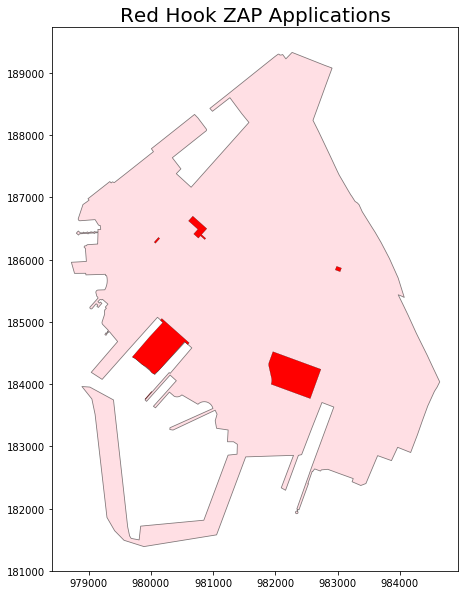

In [70]:
f, ax = plt.subplots(figsize=(15,10))
rh_tracts.plot(alpha=.5,linewidth=0.8,ax=ax,color='pink',edgecolor='black')
rh_only.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=50)
plt.title("Red Hook ZAP Applications", fontsize=20)
plt.show()

### Note:

This is a plot of all ZAPs where their centroids were located in Red Hook (relevant project areas are shaded in red while Red Hook is in pink). Note that it is possible that ZAPs centered outside of Red Hook may have included some work and redevelopment within Red Hook.

## Compare Red Hook to other parts of the city

In [31]:
rh_count = rh_only.shape[0] # + google_rh.shape[0]
rh_count_dict = {'dcp_boroug': 'Red Hook', 
                 'count':rh_count}
rh_count_dict

{'dcp_boroug': 'Red Hook', 'count': 5}

In [32]:
zap_bor_count = zap_bor_count.append(rh_count_dict, ignore_index=True)
zap_bor_count

,dcp_boroug,count
0,Bronx,215
1,Brooklyn,361
2,Manhattan,867
3,Queens,256
4,Staten Island,773
5,Red Hook,5


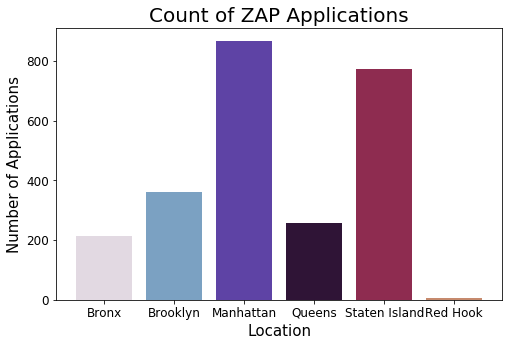

In [33]:
# Raw count for all ZAPs with complete lat lon data
x = zap_bor_count['dcp_boroug']
y = zap_bor_count['count']

plt.figure(figsize=(8,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("Count of ZAP Applications", fontsize=20)
plt.xlabel("Location", fontsize=15)
plt.ylabel("Number of Applications", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [35]:
rh_area_dict = {'dcp_boroug': 'Red Hook',
                'zap_area':rh_only.shp_area.sum(),
                'total_area':rh_tracts.geometry.area[0]}
rh_area_dict

{'dcp_boroug': 'Red Hook',
 'zap_area': 793016.0185762887,
 'total_area': 24173064.464435194}

In [36]:
zap_bor_area_merge = zap_bor_area_merge[['dcp_boroug','zap_area','total_area']]
zap_bor_area_merge = zap_bor_area_merge.append(rh_area_dict, ignore_index=True)
zap_bor_area_merge

,dcp_boroug,zap_area,total_area
0,Bronx,3.709525e+07,1.186612e+09
1,Brooklyn,6.149641e+07,1.937567e+09
2,Manhattan,9.018588e+07,6.365332e+08
3,Queens,4.374549e+08,3.044772e+09
4,Staten Island,1.536107e+08,1.623921e+09
5,Red Hook,7.930160e+05,2.417306e+07


In [37]:
zap_bor_area_merge['area_ratio'] = zap_bor_area_merge['zap_area']/zap_bor_area_merge['total_area']
zap_bor_area_merge

,dcp_boroug,zap_area,total_area,area_ratio
0,Bronx,3.709525e+07,1.186612e+09,0.031261
1,Brooklyn,6.149641e+07,1.937567e+09,0.031739
2,Manhattan,9.018588e+07,6.365332e+08,0.141683
3,Queens,4.374549e+08,3.044772e+09,0.143674
4,Staten Island,1.536107e+08,1.623921e+09,0.094593
5,Red Hook,7.930160e+05,2.417306e+07,0.032806


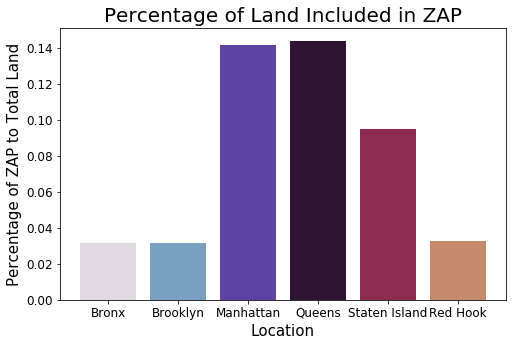

In [38]:
# Percentage of borough with ZAP applications
x = zap_bor_area_merge['dcp_boroug']
y = zap_bor_area_merge['area_ratio']

plt.figure(figsize=(8,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("Percentage of Land Included in ZAP", fontsize=20)
plt.xlabel("Location", fontsize=15)
plt.ylabel("Percentage of ZAP to Total Land", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Note:

As a fraction of its total land, the amount of land that has been included in ZAP applications is very similar to Brooklyn as a whole but far less than Manhattan or Queens.

# Google geocode (may only apply to entire dataset - not the 2010-2019 data)

Because the ZAP application data pulled from the NYC Planning Labs website was missing latitude and longitude information (and polygon shape data) for 8,415 applications, I used Google's geocoding API feature to try and fill in that missing information.

Big thanks to data scientist Shane Lynn for publishing his script that will execute batch geocoding queries. His script can be found at the following URL:

https://www.shanelynn.ie/batch-geocoding-in-python-with-google-geocoding-api/#script-code

Note that in order for the query and the next couple cells to run, you will need your own Google Maps geocoding API key saved in a text file called "google_api.txt." Do not include any other information in that file.

In [39]:
# Get a dataframe of ZAP applications missing the latitude and longitude for the project center
zap_null = zap[zap['has_centro']==0]

In [40]:
zap_null.head()

,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_1,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry
0,2019Q0306,19FDO001Q,Unlisted,FDNY EMS Station 49 Site Selection/Acquisition,FDNY seeks the site selection and acquisition ...,In Public Review,Queens,ULURP,QN01,PC,...,0.0,0.0,0.0,FDNY,2019-07-15,2796,0,None,190424PCQ,None
7,P2017Q0185,None,None,JFK North Site - City Map Change,"An application by a private applicant, Jughand...",In Public Review,Queens,ULURP,QN13,MM,...,0.0,0.0,0.0,Economic Development Corporation,2019-07-01,2796,0,None,C180517MMQ,None
18,P2017R0360,19DCP150R,Type II,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA,...,0.0,0.0,0.0,Peter Calvanico,2019-06-10,2796,0,None,N190308ZAR;N190310ZAR,None
20,2019M0149,19DCP110Y,Type I,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,...,0.0,0.0,0.0,DCP,2019-06-03,2796,0,None,N190230ZRY,None
26,2019K0316,19DCP197K,Type II,Green Gems Garden Addition,This is an application by DPR and DCAS request...,In Public Review,Brooklyn,ULURP,BK05,PC,...,0.0,0.0,0.0,DPR,2019-05-20,2796,0,None,190452PCK,None


In [41]:
# Form a list of addresses for geocoding:
addresses = (zap_null['dcp_projec'] + ', ' + zap_null['dcp_boroug'] + ', NY, US').tolist()

In [42]:
# To retrieve API key for following query
API_KEY = open('api/google_api.txt', 'r').readlines()[0][:] # api stored in seperate .txt file

In [43]:
# Function
def get_google_results(address, api_key=None, return_full_response=False):
    # Set up Geocoding url
    geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}".format(address)
    if api_key is not None:
        geocode_url = geocode_url + "&key={}".format(api_key)
        
    # Ping google for the reuslts:
    results = requests.get(geocode_url)
    # Results will be in JSON format - convert to dict using requests functionality
    results = results.json()
    
    # if there's no results or an error, return empty results.
    if len(results['results']) == 0:
        output = {
            "formatted_address" : None,
            "latitude": None,
            "longitude": None,
            "accuracy": None,
            "google_place_id": None,
            "type": None,
            "postcode": None
        }
    else:    
        answer = results['results'][0]
        output = {
            "formatted_address" : answer.get('formatted_address'),
            "latitude": answer.get('geometry').get('location').get('lat'),
            "longitude": answer.get('geometry').get('location').get('lng'),
            "accuracy": answer.get('geometry').get('location_type'),
            "google_place_id": answer.get("place_id"),
            "type": ",".join(answer.get('types')),
            "postcode": ",".join([x['long_name'] for x in answer.get('address_components') 
                                  if 'postal_code' in x.get('types')])
        }
        
    # Append some other details:    
    output['input_string'] = address
    output['number_of_results'] = len(results['results'])
    output['status'] = results.get('status')
    if return_full_response is True:
        output['response'] = results
    
    return output

### API request for all missing address info

In [44]:
# Function for api call
def google_geo_api(chunk):
    # Create a list to hold results
    results = []
    # Go through each address in turn
    for address in chunk:
        geocode_result = get_google_results(address, API_KEY)
        results.append(geocode_result)           
    return results

In [45]:
# Only uncomment if you want to rerun and request 8k+ API calls
# all_results = google_geo_api(addresses)

In [46]:
# All results have already been pulled from Google and saved as csv
google_results = pd.read_csv('data/zap_google_geocode/all_zap_geocoded.csv')
google_results.head()

,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type
0,ROOFTOP,"45 Douglas Ct, Staten Island, NY 10304, USA",ChIJ8_sf4PZOwokRkHmQtiRNrvk,"45 Douglas Court, Staten Island, NY, US",40.608527,-74.091696,1,10304,OK,street_address
1,APPROXIMATE,"Manhattan, New York, NY, USA",ChIJYeZuBI9YwokRjMDs_IEyCwo,Residential Tower Mechanical Voids Text Amendm...,40.783060,-73.971249,1,NaN,OK,"political,sublocality,sublocality_level_1"
2,ROOFTOP,"217 Main St, Staten Island, NY 10307, USA",ChIJe41FVZnKw4kRNZEBZ286_zg,"SS 217 Main Street, Staten Island, NY, US",40.509931,-74.247232,1,10307,OK,premise
3,ROOFTOP,"66 Hudson Blvd E, West, NY 10001, USA",ChIJSbI7fbNZwokRhr1NS-eDyHc,66 Hudson Boulevard Streetscape Text Amendment...,40.755680,-74.000510,1,10001,OK,street_address
4,APPROXIMATE,"Brooklyn, NY, USA",ChIJCSF8lBZEwokRhngABHRcdoI,Consolidation of ACS Division of Child Protect...,40.678178,-73.944158,1,NaN,OK,"political,sublocality,sublocality_level_1"


In [47]:
# Number of results returned
google_results.shape

(8415, 10)

In [48]:
# Turn that df into a gdf
google_results['lonlat'] = list(zip(google_results.longitude, google_results.latitude))
google_results['geometry'] = google_results[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
google_results = gpd.GeoDataFrame(google_results)
google_results.crs = from_epsg(4326)
google_results.to_crs(epsg=2263, inplace = True)

In [49]:
# Join the Google results with the Red Hook census tracts to see which ones fall within Red Hook
google_rh = gpd.tools.sjoin(rh_tracts,google_results)
google_rh.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,...,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type,lonlat
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"700 Columbia St, Brooklyn, NY 11231, USA",ChIJmWYrzpZawokRcLQJiIrmZxs,"POLICE AUTO POUND, Queens, NY, US",40.665264,-74.014326,1,11231,OK,"establishment,point_of_interest,police","(-74.0143265, 40.6652641)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"5 Sigourney St 2nd floor, Brooklyn, NY 11231, USA",ChIJgXgKRYxawokRYcQddJBiLps,"MURRELL BUS, Citywide, NY, US",40.673361,-74.010304,2,11231,OK,"establishment,point_of_interest,travel_agency","(-74.01030379999997, 40.6733615)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"Red Hook, Brooklyn, NY, USA",ChIJv4cTh4tawokRQFmjdeb5YyI,"RED HOOK POLLUTION CONTROL PLANT, Brooklyn, NY...",40.673368,-74.008319,1,NaN,OK,"neighborhood,political","(-74.00831889999998, 40.67336760000001)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"Red Hook, Brooklyn, NY, USA",ChIJv4cTh4tawokRQFmjdeb5YyI,"RED HOOK WATER POLLUTION, Brooklyn, NY, US",40.673368,-74.008319,1,NaN,OK,"neighborhood,political","(-74.00831889999998, 40.67336760000001)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"Red Hook, Brooklyn, NY, USA",ChIJv4cTh4tawokRQFmjdeb5YyI,"2ND AMENDMENT TO RED HOOK URP, Brooklyn, NY, US",40.673368,-74.008319,1,NaN,OK,"neighborhood,political","(-74.00831889999998, 40.67336760000001)"


In [50]:
# Fix the geometry column
google_rh.drop(['geometry'], axis=1, inplace=True)

In [51]:
# Create a new geometry column
google_rh['geometry'] = google_rh[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
google_rh.reset_index(drop=True, inplace=True)

In [52]:
google_rh.crs = from_epsg(4326)
google_rh.to_crs(epsg=2263, inplace = True)

## Dropping some Google results

I dropped some of the results from the Google API call since they don't appear to be related to Red Hook based on the project names. I won't be able to do this for the other results for other boroughs since there are too many rows to review. But there are probably many false positives so I'm not going to merge those results from Google back with the original data.

In [53]:
google_rh.input_string.values

array(['POLICE AUTO POUND, Queens, NY, US',
       'MURRELL BUS, Citywide, NY, US',
       'RED HOOK POLLUTION CONTROL PLANT, Brooklyn, NY, US',
       'RED HOOK WATER POLLUTION, Brooklyn, NY, US',
       '2ND AMENDMENT TO RED HOOK URP, Brooklyn, NY, US',
       'RED HOOK PENINSULA 3RD AMEND URP, Brooklyn, NY, US',
       'CREAMER ST BET HICKS & COLUMBIA STS, Brooklyn, NY, US',
       'RED HOOK I, Brooklyn, NY, US',
       'COFFEY ST BET CONOVER & VANBRUNT STS (RED HOOK), Brooklyn, NY, US',
       '168 COFFEY ST, Brooklyn, NY, US',
       'COLUMBIA ST URA, Brooklyn, NY, US',
       'COLUMBIA ST URA, Brooklyn, NY, US',
       'KING,CONOVER,SULLIVAN,WOLCOTT,FERRIS,DIKEMAN STS, Brooklyn, NY, US',
       'HISTORIC RED HOOK TROLLEY, Brooklyn, NY, US',
       'STG II REDHOOK MARINE TER, Brooklyn, NY, US',
       '21ST ST WEST OF 2ND AVE ON GOUANUS CREEK, Brooklyn, NY, US',
       'COLUMBIA ST URA, Brooklyn, NY, US',
       'COLUMBIA HICKS PROJ, Brooklyn, NY, US'], dtype=object)

In [54]:
"""
Removing: 

- Police auto pound
- Murrell Bus
- "KING,CONOVER,SULLIVAN,WOLCOTT,FERRIS,DIKEMAN STS, Brooklyn, NY, US"
- "21ST ST WEST OF 2ND AVE ON GOUANUS CREEK, Brooklyn, NY, US"

"""
google_rh.drop([0,1,14,17], inplace=True)

In [55]:
# Bring in more data for plotting
rh_centroid = gpd.read_file('data/created_data/rh_centroid/rh_centroid.shp')
site_poly = gpd.read_file('data/created_data/site/site_poly/site_poly.shp')
site_centroid = gpd.read_file('data/created_data/site/site_centroid/site_centroid.shp')

In [56]:
# Reset epsg
rh_centroid.to_crs(epsg=2263, inplace = True)
site_poly.to_crs(epsg=2263, inplace = True)
site_centroid.to_crs(epsg=2263, inplace = True)

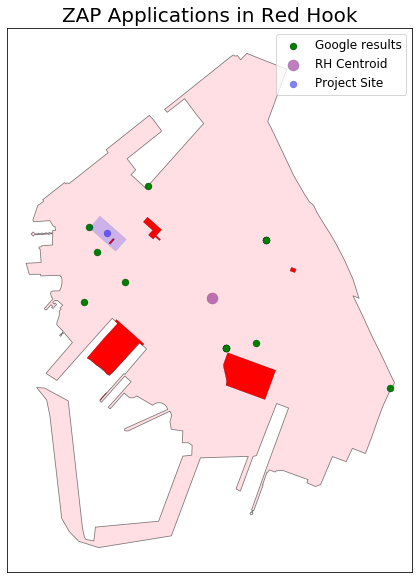

In [71]:
f, ax = plt.subplots(figsize=(10,10))
rh_tracts.plot(alpha=.5,linewidth=0.8,ax=ax,color='pink',edgecolor='black')
rh_only.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=125,label='Original Data')
google_rh.plot(alpha=1, linewidth=0.2,ax=ax,color='g',edgecolor='black',markersize=50,label='Google results')
rh_centroid.plot(alpha=.5, linewidth=0.2,ax=ax,color='purple',edgecolor='black',markersize=125,label='RH Centroid')
site_poly.plot(alpha=.2, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=100)
site_centroid.plot(alpha=.5, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=50, \
                   label='Project Site')
plt.title("ZAP Applications in Red Hook", fontsize=20)
plt.legend(fontsize=12)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

### Note:

We can see that after pulling in the results from Google, there are even more ZAP projects that weren't included in the data returned from the NYC Planning Labs website. Unfortunately, we don't know the size or exact dimensions of these sites. With further research, we might be able to track down that information.

## Merge back with original data to fill in missing lat lon info

If I decide to look into the Google results more, here's how I could merge the data back in with the original dataframe that was missing latitude and longitude data.

In [58]:
# Create a column for the input string that was used to query the Google Geocode API
zap_null['input_string'] = zap_null['dcp_projec'] + ', ' + zap_null['dcp_boroug'] + ', NY, US'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [59]:
zap_null.reset_index(drop=True, inplace=True)

In [60]:
# Just keep the unique rows because that was causing merge issues
zap_null = zap_null.drop_duplicates(subset='input_string', keep='first')
zap_null.head()

,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,dcp_fema_2,dcp_fema_3,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry,input_string
0,2019Q0306,19FDO001Q,Unlisted,FDNY EMS Station 49 Site Selection/Acquisition,FDNY seeks the site selection and acquisition ...,In Public Review,Queens,ULURP,QN01,PC,...,0.0,0.0,FDNY,2019-07-15,2796,0,None,190424PCQ,None,FDNY EMS Station 49 Site Selection/Acquisition...
1,P2017Q0185,None,None,JFK North Site - City Map Change,"An application by a private applicant, Jughand...",In Public Review,Queens,ULURP,QN13,MM,...,0.0,0.0,Economic Development Corporation,2019-07-01,2796,0,None,C180517MMQ,None,"JFK North Site - City Map Change, Queens, NY, US"
2,P2017R0360,19DCP150R,Type II,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA,...,0.0,0.0,Peter Calvanico,2019-06-10,2796,0,None,N190308ZAR;N190310ZAR,None,"45 Douglas Court, Staten Island, NY, US"
3,2019M0149,19DCP110Y,Type I,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,...,0.0,0.0,DCP,2019-06-03,2796,0,None,N190230ZRY,None,Residential Tower Mechanical Voids Text Amendm...
4,2019K0316,19DCP197K,Type II,Green Gems Garden Addition,This is an application by DPR and DCAS request...,In Public Review,Brooklyn,ULURP,BK05,PC,...,0.0,0.0,DPR,2019-05-20,2796,0,None,190452PCK,None,"Green Gems Garden Addition, Brooklyn, NY, US"


In [61]:
# Just keep the columns we need from the Google results
google_results = google_results[['input_string', 'latitude', 'longitude']]

In [62]:
# And drop duplicate rows
google_results.drop_duplicates(subset='input_string', keep='first', inplace=True)

In [63]:
# Merge in the Google results
zap_concat = zap_null.merge(google_results, how='inner', left_on='input_string', right_on='input_string')
zap_concat.head()

,dcp_name,dcp_ceqrnu,dcp_ceqrty,dcp_projec,dcp_proj_1,dcp_public,dcp_boroug,dcp_ulurp_,dcp_commun,actiontype,...,applicants,lastmilest,total_proj,has_centro,center,ulurpnumbe,geometry,input_string,latitude,longitude
0,2019Q0306,19FDO001Q,Unlisted,FDNY EMS Station 49 Site Selection/Acquisition,FDNY seeks the site selection and acquisition ...,In Public Review,Queens,ULURP,QN01,PC,...,FDNY,2019-07-15,2796,0,None,190424PCQ,None,FDNY EMS Station 49 Site Selection/Acquisition...,40.772892,-73.921150
1,P2017Q0185,None,None,JFK North Site - City Map Change,"An application by a private applicant, Jughand...",In Public Review,Queens,ULURP,QN13,MM,...,Economic Development Corporation,2019-07-01,2796,0,None,C180517MMQ,None,"JFK North Site - City Map Change, Queens, NY, US",40.641311,-73.778139
2,P2017R0360,19DCP150R,Type II,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA,...,Peter Calvanico,2019-06-10,2796,0,None,N190308ZAR;N190310ZAR,None,"45 Douglas Court, Staten Island, NY, US",40.608527,-74.091696
3,2019M0149,19DCP110Y,Type I,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,...,DCP,2019-06-03,2796,0,None,N190230ZRY,None,Residential Tower Mechanical Voids Text Amendm...,40.783060,-73.971249
4,2018M0372,19DCP134M,Unlisted,25 Central Park West,This is a private application to facilitate a ...,In Public Review,Manhattan,ULURP,MN07,ZM,...,American Continental Properties,2019-05-20,2796,0,None,190390ZMM,None,"25 Central Park West, Manhattan, NY, US",40.770290,-73.980546


In [64]:
# Number of rows Google was able to match
zap_concat.shape

(306, 25)

# Next steps

### Dana's comments:

* Limit the time - since when is the data? - Done
* Staten Island: either remove from the comparison or try to filter the overall data to include big projects / zonings / changes. - Done (I didn't know there was a shapefile I could use but I pulled that instead of the raw counts.)

### My own list

* We're trying to answer questions like: "How does Red Hook compare to the rest of Brooklyn? What about the rest of NYC?"
* Merge back with the original data if you have time